In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

import argparse
import logging
from tqdm import tqdm
import numpy as np
import pandas as pd
import logging
import os
import math
import copy
import matplotlib.pyplot as plt
import optuna
from datetime import datetime
import random
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
import copy

import scipy.stats

In [103]:
import sys
sys.path.append('..')

In [104]:
from src.data.data_loader import MIMICDataset,import_data
from src.utils import setup_logger
from src.training.training_nn import *
from src.models.models import ODERNN,GRU
from src.utils import seed_everything

In [105]:
def glc_transform(x):
    x = x.copy()
    x[x > 0] = np.log(x[x > 0]) - np.log(140)
    return x

def glc_invtransform(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

ginv = glc_invtransform

In [106]:
DATA_PATH = "../data/analysis.csv"
df = import_data(DATA_PATH)


excluding: 211846
excluding: 264238
excluding: 297331
excluding: 261264
excluding: 205074
excluding: 297801
excluding: 279326
excluding: 225659
excluding: 232921
excluding: 227412
excluding: 205994
excluding: 214363
excluding: 287055
excluding: 291764
excluding: 248411
excluding: 266873
excluding: 268199
excluding: 235137
excluding: 220805
excluding: 258014
excluding: 289703
excluding: 223996
excluding: 221391
excluding: 281374
excluding: 204747
excluding: 223704
excluding: 251319
excluding: 261819
excluding: 278095
excluding: 259808
excluding: 222242
excluding: 218639
excluding: 218465
excluding: 284881
excluding: 284284
excluding: 285966
excluding: 291611
excluding: 268578
excluding: 272859
excluding: 229041
excluding: 239443
excluding: 221828
excluding: 252077
excluding: 262484
excluding: 280186
excluding: 202559
excluding: 288669
excluding: 277462
excluding: 296952
excluding: 210562
excluding: 280745
excluding: 251758
excluding: 278934
excluding: 288807
excluding: 221033
excluding:

In [107]:
print(df.shape)

(392756, 9)


In [6]:
# seed

df.glc = glc_transform(df.glc)
df.glc_dt = glc_transform(df.glc_dt)
df['t0'] = df.timer_hr
df['t1'] = df.timer_hr + df.dt


In [7]:
df.loc[df.icustay_id == 214619].iloc[0:20,:]

,icustay_id,timer_hr,injection,input_hrs,input,glc,dt,glc_1,msk,t0,t1
131,214619,6.527500,0,0.0,0.0,-0.007168,3.133333,NaN,1,6.527500,9.660833
132,214619,9.660833,1,0.0,2.0,NaN,5.466667,0.000000,0,9.660833,15.127500
133,214619,15.127500,0,0.0,0.0,0.000000,0.183333,NaN,1,15.127500,15.310833
134,214619,15.310833,1,0.0,2.0,NaN,4.983333,0.088795,0,15.310833,20.294167
135,214619,20.294167,0,0.0,0.0,0.088795,1.333333,NaN,1,20.294167,21.627500
136,214619,21.627500,1,0.0,4.0,NaN,5.500000,-0.250295,0,21.627500,27.127500
137,214619,27.127500,0,0.0,0.0,-0.250295,6.000000,-0.232112,0,27.127500,33.127500
138,214619,33.127500,0,0.0,0.0,-0.232112,6.583333,-0.121361,0,33.127500,39.710833
139,214619,39.710833,0,0.0,0.0,-0.121361,5.350000,-0.097455,0,39.710833,45.060833
140,214619,45.060833,0,0.0,0.0,-0.097455,0.066667,NaN,1,45.060833,45.127500


In [8]:
df['glc'] = df.groupby('icustay_id').glc.fillna(method='ffill')
df = df.loc[~df.glc.isnull()]

for id_ in df.icustay_id.unique():
    df_id = df.loc[df.icustay_id == id_,:]
    if (sum(df_id.msk) == df_id.shape[0]):
        df.drop(df.loc[df.icustay_id == id_,:].index,inplace=True)
        print("excluding:",id_)

excluding: 256919
excluding: 294754
excluding: 226871
excluding: 259557
excluding: 244481
excluding: 278881
excluding: 215858
excluding: 203601
excluding: 297226
excluding: 270562
excluding: 253103
excluding: 213252
excluding: 233427
excluding: 210919
excluding: 229391
excluding: 214980
excluding: 235909
excluding: 283329
excluding: 288876
excluding: 246711
excluding: 242544
excluding: 271802
excluding: 259510
excluding: 240831
excluding: 256330
excluding: 215799
excluding: 257328
excluding: 262192
excluding: 283259
excluding: 282645
excluding: 294375
excluding: 224125
excluding: 207781
excluding: 276632
excluding: 294864
excluding: 215429
excluding: 276835


In [9]:
# df['input'] = df['input']/50
# df['input_hrs'] = df['input_hrs']/30

qt = QuantileTransformer(n_quantiles=10, random_state=0)
df['input'] = qt.fit_transform(df['input'].to_numpy().reshape(-1, 1))
qt = QuantileTransformer(n_quantiles=10, random_state=0)
df['input_hrs'] = qt.fit_transform(df['input_hrs'].to_numpy().reshape(-1, 1))

# sample_ids = df.icustay_id.unique()[0:2000]
# train_ids, test_ids = train_test_split(sample_ids,test_size=0.25)

train_ids, test_ids = train_test_split(df.icustay_id.unique(),test_size=0.25)

df_train = df.loc[df.icustay_id.isin(train_ids)]
df_valid = df.loc[df.icustay_id.isin(test_ids)]


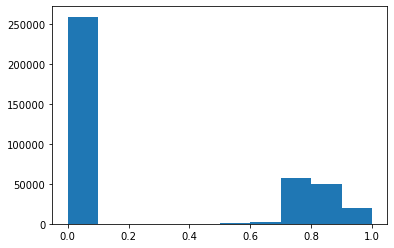

In [10]:
plt.hist(df['input_hrs'])
plt.show()

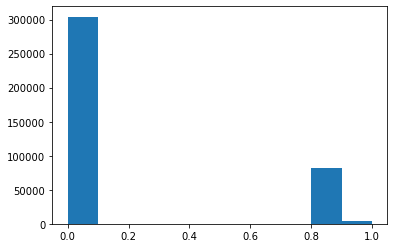

In [11]:
plt.hist(df['input'])
plt.show()

In [12]:
FEATURE_VARS = ["injection","input_hrs","input","glc"]
TIME_VARS = ["t0","t1"]

class MIMICDataset(Dataset):
    """
    Args:
        patientunitstayids: 
        df:
        ...
    
    Example:
    """
    def __init__(self,df,verbose=True):
        self.X,self.y,self.msk,self.dt = self.load_data(df,verbose=verbose)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx],self.y[idx],self.msk[idx],self.dt[idx]
    
    def load_data(self,df,verbose):
        X_list, y_list, msk_list, dt_list = [], [], [], []
        ids = df.icustay_id.unique()
        if verbose:
            print("reconfiguring data...")
        for id_ in ids:
            df_id = df.loc[df.icustay_id == id_,:]
            if (sum(df_id.msk) == df_id.shape[0]):
                print("excluding:",id_)
                continue
            X = df_id.loc[:,FEATURE_VARS]
            y = df_id.loc[:,"glc_dt"]
            msk = df_id.loc[:,"msk"]
            dt = df_id.loc[:,TIME_VARS]
            X = np.array(X).astype(np.float32)
            y = np.array(y).astype(np.float32)
            msk = np.array(msk).astype(np.int32)
            dt = np.array(dt).astype(np.float32)
            X_list.append(X)
            y_list.append(y)
            msk_list.append(msk)
            dt_list.append(dt)
        return X_list,y_list,msk_list,dt_list

In [13]:
dl_train = DataLoader(MIMICDataset(df_train),batch_size=1)
dl_valid = DataLoader(MIMICDataset(df_valid),batch_size=1)
dataloaders = {'train':dl_train,'validation':dl_valid}

reconfiguring data...
reconfiguring data...


In [14]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
#from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import math

# Base ----------------------------------------------------------------------------

import torch.nn.functional as F

class Baseline(nn.Module):
    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        super(Baseline, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.p = p
        self.device = device
        
    def train_single_epoch(self,dataloader,optim):
        loss = 0.0
        for i, (x, y, msk, dt) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.view(-1,1).to(self.device)
            dt = dt.to(self.device)
            msk = msk.bool().to(self.device)
            optim.zero_grad()
            preds = self.forward(dt,x)
            loss_step = self.loss_fn(preds,y,~msk.squeeze(0))
            loss_step.backward()
            #torch.nn.utils.clip_grad_norm_(self.parameters(), 10.0)
            optim.step()
            loss += loss_step.item()
            if i % 1e3 == 0:
                print("BATCH_loss : {:05.3f}".format(loss_step.item()))
        loss /= (i + 1)
        print("EPOCH_loss : {:05.3f}".format(loss))
        
        return loss
        
    def evaluate(self,dataloader,p=0.0):
        rmse, loss = 0., 0.
        N = 0
        y_preds = []
        y_tests = []
        msks = []
        #dts = []
        with tqdm(total=len(dataloader)) as t:
            for i, (x, y, msk, dt) in enumerate(dataloader):
                N += sum((msk == 0).squeeze(0)).item()
                x = x.to(self.device)
                y = y.view(-1,1).to(self.device)
                dt = dt.to(self.device)
                # model prediction
                y_ = self.forward(dt,x)
                y_preds.append([yc.detach().cpu().numpy() for yc in y_]) 
                y_tests.append(y.cpu().numpy())
                msk = msk.bool().to(self.device)
                rmse += self.get_sse(y_,y,~msk.squeeze(0)).item()
                loss += self.loss_fn(y_,y,~msk.squeeze(0)).item()
                msks.append(msk.cpu().numpy())
                t.update()
        rmse /= N
        loss /= (i + 1)
        rmse = math.sqrt(rmse)
        print("_rmse : {:05.3f}".format(rmse))
        print("_loss : {:05.3f}".format(loss))
        return loss,rmse, y_preds, y_tests, msks

    def get_sse(self,y_,y,msk):
        """
        SSE: sum of squared errors
        """
        if type(y_) == tuple:
            y_ = y_[0]
        c = torch.log(torch.tensor(140.0))
        rmse = torch.sum((torch.exp(y_[msk] + c) - torch.exp(y[msk] + c))**2)
        return rmse

In [15]:
    
class ODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,input_dim,hidden_dim):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_dim),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, z, x):
        zx = torch.cat((z,x),1)
        return self.net(zx)
    
class LatentODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = ODEFunc(input_dim,hidden_dim).to(device)
        self.sigma = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        )
        self.mu = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, dt, x):
        
        
        x = x.squeeze(0)
        dt = dt.squeeze(0)
        T = x.size(0)
        
        mu_out,sigma_out= torch.zeros(T,1,device = self.device),torch.zeros(T,1,device = self.device) 
        z_t = torch.zeros(1,self.hidden_dim,device = self.device)
        for i in range(0,T):
            
            # embedding layer
            # ....
            
            # encode - ODE
            x_i = x[i].unsqueeze(0)
            z_t = self.euler(self.func,z_t.clone(),x_i,dt[i],h=1.0)
            
            # output layer 
            sigma = self.sigma(z_t.clone())
            mu = self.mu(z_t.clone())
            sigma_out[i] = sigma
            mu_out[i] = mu
        
        return (mu_out,sigma_out)
    
    def loss_fn(self,mu_s_,y,msk):
        y_, s_ = mu_s_
        distribution = torch.distributions.normal.Normal(y_[msk], s_[msk])
        likelihood = distribution.log_prob(y[msk])
        return -torch.mean(likelihood)

    def euler(self,func,y0,x,t,h):
        if (t[1]-t[0]) == 0:
            return y0
        else :
            tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
            hs = torch.diff(tsteps)
            #y = copy.deepcopy(y0)
            y = y0
            for h in hs:
                y += h*func(y,x)
        return y 


In [16]:
    
class ODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,input_dim,hidden_dim):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_dim),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, z):
        return self.net(z)

class LatentODE1(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.encoder = nn.LSTMCell(input_dim,hidden_dim)
        self.func = ODEFunc(input_dim,hidden_dim).to(device)
        self.sigma = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        )
        self.mu = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, dt, x):
        
        
        x = x.squeeze(0)
        dt = dt.squeeze(0)
        T = x.size(0)
        
        mu_out,sigma_out = torch.zeros(T,1,device = self.device),torch.zeros(T,1,device = self.device) 
        #z_t = torch.zeros(1,self.hidden_dim,device = self.device)
        z_1 = torch.zeros(1,self.hidden_dim,device = self.device)
        c_1 = torch.zeros(1,self.hidden_dim,device = self.device)
        for i in range(0,T):
            # encode 
            z_1,c_1 = self.encoder(x[i].unsqueeze(0),(z_1.detach().clone(),c_1.detach().clone()))
            
            # ODE
            z_2 = self.euler(self.func,z_1,dt[i],1.0)
            
            # decode 
            sigma = self.sigma(z_2)
            mu = self.mu(z_2)
            sigma_out[i] = sigma
            mu_out[i] = mu
        
        return (mu_out,sigma_out)
    
    def loss_fn(self,mu_s_,y,msk):
        y_, s_ = mu_s_
        distribution = torch.distributions.normal.Normal(y_[msk], s_[msk])
        likelihood = distribution.log_prob(y[msk])
        return -torch.mean(likelihood)
    
    def euler(self,func,z0,t,h):
        if (t[1]-t[0]) == 0:
            return z0
        else:
            tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
            hs = torch.diff(tsteps)
            #y = copy.deepcopy(y0)
            z = z0.detach().clone()
            for h in hs:
                z += h*func(z.detach().clone())
        return z 



In [17]:
    
class ODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,input_dim,hidden_dim):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_dim),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, z, x=None):
        if x != None:
            zx = torch.cat((z,x),1)
        else:
            zx = z
        return self.net(zx)
    
class LatentODE2(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = ODEFunc(input_dim,hidden_dim).to(device)
        self.dfunc = ODEFunc(0,hidden_dim).to(device)
        self.sigma = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        )
        self.mu = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, dt, x):
        
        
        x = x.squeeze(0)
        dt = dt.squeeze(0)
        T = x.size(0)
        
        mu_out,sigma_out= torch.zeros(T,1,device = self.device),torch.zeros(T,1,device = self.device) 
        z_t = torch.zeros(1,self.hidden_dim,device = self.device)
        for i in range(0,T):
            # update hidden state
            z_t = self.euler1(self.dfunc,z_t.clone(),dt[i],h=1.0)
            
            # encode ODE
            x_i = x[i].unsqueeze(0)
            z_t = self.euler(self.func,z_t.clone(),x_i,dt[i],h=1.0)
            
            # decode 
            sigma = self.sigma(z_t.clone())
            mu = self.mu(z_t.clone())
            sigma_out[i] = sigma
            mu_out[i] = mu
        
        return (mu_out,sigma_out)
    
    def loss_fn(self,mu_s_,y,msk):
        y_, s_ = mu_s_
        distribution = torch.distributions.normal.Normal(y_[msk], s_[msk])
        likelihood = distribution.log_prob(y[msk])
        return -torch.mean(likelihood)

    def euler(self,func,y0,x,t,h):
        if (t[1]-t[0]) == 0:
            return y0
        else :
            tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
            hs = torch.diff(tsteps)
            #y = copy.deepcopy(y0)
            y = y0
            for h in hs:
                y += h*func(y,x)
        return y 

    def euler1(self,func,y0,t,h):
        if (t[1]-t[0]) == 0:
            return y0
        else :
            tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
            hs = torch.diff(tsteps)
            #y = copy.deepcopy(y0)
            y = y0.detach().clone()
            for h in hs:
                y += h*func(y.detach().clone())
        return y 


In [18]:
model = LatentODE(4, 8, 0.5, 1, "cuda").to("cuda")

In [19]:
t = next(iter(dl_train))[3].squeeze(0).to("cuda")
x = next(iter(dl_train))[0].squeeze(0).to("cuda")
y = next(iter(dl_train))[1].squeeze(0)
msk = next(iter(dl_train))[2].squeeze(0)
y_ = model(t,x)
#print(y_[1])
#model(t[:1].unsqueeze(0),x[:1].unsqueeze(0))
# model(t[0],x[0]) # doesn't work but that's okay

In [20]:
model_optim = optim.RMSprop(model.parameters(), lr=1e-3)

In [21]:
model.train_single_epoch(dl_train,model_optim)
model.train_single_epoch(dl_train,model_optim)
model.train_single_epoch(dl_train,model_optim)

BATCH_loss : 0.822
BATCH_loss : 0.255
BATCH_loss : 0.306
BATCH_loss : -0.110
BATCH_loss : -0.102
BATCH_loss : 0.505
BATCH_loss : 0.300
BATCH_loss : -0.275
BATCH_loss : 0.088
EPOCH_loss : 0.133
BATCH_loss : 0.417
BATCH_loss : 0.134
BATCH_loss : 0.281
BATCH_loss : -0.172
BATCH_loss : -0.148
BATCH_loss : 0.438
BATCH_loss : 0.294
BATCH_loss : -0.268
BATCH_loss : 0.114
EPOCH_loss : 0.062
BATCH_loss : 0.190
BATCH_loss : 0.139
BATCH_loss : 0.299
BATCH_loss : -0.163
BATCH_loss : -0.130
BATCH_loss : 0.434
BATCH_loss : 0.339
BATCH_loss : -0.279
BATCH_loss : 0.090
EPOCH_loss : 0.054


0.05367414123724263

In [22]:
loss,rmse, y_preds, y_tests, msks = model.evaluate(dl_valid)

100%|██████████| 2797/2797 [02:30<00:00, 18.54it/s]

_rmse : 38.774
_loss : 0.037


In [1]:
rmse

NameError: name 'rmse' is not defined

In [24]:
df_valid["glc_dt_locf"] = df_valid.glc
df_valid.loc[df_valid.glc_dt_locf == 0,'glc_dt_locf'] = np.NaN
df_valid["glc_dt_locf"] = df_valid.groupby('icustay_id')["glc_dt_locf"].ffill()
res_rmse_locf = math.sqrt(np.mean((ginv(df_valid.glc_dt_locf[df_valid.msk==0]) - ginv(df_valid.glc_dt[df_valid.msk==0]))**2))
print("RMSE (locf): {:05.4f}".format(res_rmse_locf))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

RMSE (locf): 42.7021


In [25]:
math.sqrt(np.mean((df_valid.glc[df_valid.msk==0] - df_valid.glc_dt[df_valid.msk==0])**2))

0.2744527608038444

In [26]:
rmse / res_rmse_locf

0.9080123487455226

In [27]:
mu_preds = [y[0] for y in y_preds]
s_preds = [y[1] for y in y_preds]

In [28]:
mu_preds = np.concatenate(mu_preds)
y_tests = np.concatenate(y_tests)

In [29]:
s_preds = np.concatenate(s_preds)

In [30]:
df_valid['mu_preds'] = mu_preds
df_valid['s_preds'] = s_preds

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
dts = np.linspace(0,11,12)
dts = np.append(dts,12.)
for i in range(dts.shape[0]-1):
    print('time ahead (hours): {:05.2f}-{:05.2f}'.format(dts[i],dts[i+1]))
    msk = (df_valid.msk==0) & (df_valid.dt >= dts[i]) & (df_valid.dt < dts[i+1])
    print("N: {:5}".format(sum(msk)))
    res_rmse_locf = math.sqrt(np.mean((ginv(df_valid.glc_dt_locf[msk]) - ginv(df_valid.glc_dt[msk]))**2))
    print("RMSE (locf): {:05.4f}".format(res_rmse_locf))
    res_rmse_model = math.sqrt(np.mean((ginv(df_valid.mu_preds[msk]) - ginv(df_valid.glc_dt[msk]))**2))
    print("RMSE (model): {:05.4f}".format(res_rmse_model))
    print("{:05.4f}".format(res_rmse_model/res_rmse_locf))

time ahead (hours): 00.00-01.00
N: 12994
RMSE (locf): 34.8289
RMSE (model): 34.8033
0.9993
time ahead (hours): 01.00-02.00
N: 13162
RMSE (locf): 35.0508
RMSE (model): 32.4935
0.9270
time ahead (hours): 02.00-03.00
N:  4179
RMSE (locf): 45.7201
RMSE (model): 42.6710
0.9333
time ahead (hours): 03.00-04.00
N:  3012
RMSE (locf): 55.1400
RMSE (model): 49.0660
0.8898
time ahead (hours): 04.00-05.00
N:  3746
RMSE (locf): 54.2085
RMSE (model): 48.2914
0.8908
time ahead (hours): 05.00-06.00
N:  7417
RMSE (locf): 48.8122
RMSE (model): 41.9843
0.8601
time ahead (hours): 06.00-07.00
N:  7041
RMSE (locf): 42.6655
RMSE (model): 37.5998
0.8813
time ahead (hours): 07.00-08.00
N:  1087
RMSE (locf): 48.6503
RMSE (model): 42.6095
0.8758
time ahead (hours): 08.00-09.00
N:   593
RMSE (locf): 50.5273
RMSE (model): 40.2239
0.7961
time ahead (hours): 09.00-10.00
N:   491
RMSE (locf): 58.5637
RMSE (model): 49.6358
0.8476
time ahead (hours): 10.00-11.00
N:   543
RMSE (locf): 52.2484
RMSE (model): 44.9420
0.8602

[295385]


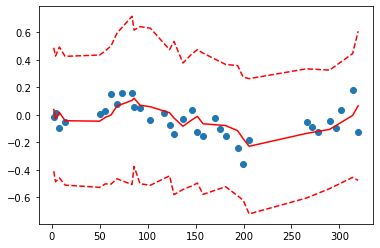

In [32]:
ids = df_valid.icustay_id.unique()
id_ = random.sample(list(ids),1)
print(id_)
df_i = df_valid.loc[(df_valid.icustay_id == id_[0])]
plt.scatter(df_i.t1,df_i.glc_dt)
plt.plot(df_i.t1[df_i.msk == 0],df_i.mu_preds[df_i.msk == 0],'-r')
plt.plot(df_i.t1[df_i.msk == 0],df_i.mu_preds[df_i.msk == 0] + 2*df_i.s_preds[df_i.msk == 0],'--r')
plt.plot(df_i.t1[df_i.msk == 0],df_i.mu_preds[df_i.msk == 0] - 2*df_i.s_preds[df_i.msk == 0],'--r')

In [33]:
msks = np.concatenate([msk[0] for msk in msks])

In [34]:
prob_test = scipy.stats.norm(mu_preds[~msks].reshape(-1,1), s_preds[~msks].reshape(-1,1)).cdf(y_tests[~msks])

(array([3593., 4471., 6012., 7260., 7993., 8000., 7091., 5804., 4386.,
        3488.]),
 array([1.31193948e-23, 9.99999999e-02, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        7.99999999e-01, 8.99999999e-01, 9.99999999e-01]),
 <BarContainer object of 10 artists>)

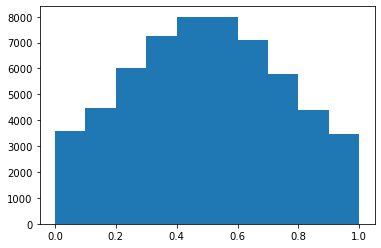

In [35]:
plt.hist(prob_test)

In [36]:
print("variance of probabilities:")
np.var(prob_test)

variance of probabilities:


0.06281430287357101

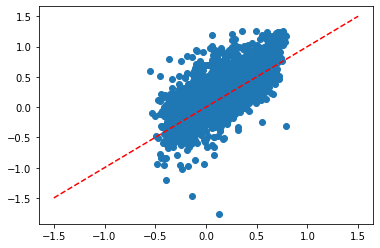

In [37]:
plt.scatter(mu_preds[msks],y_tests[msks])
xs = np.linspace(-1.5,1.5)
plt.plot(xs,xs,'--r')

In [38]:
t = next(iter(dl_train))[3].squeeze(0).to("cuda")
x = next(iter(dl_train))[0].squeeze(0).to("cuda")
y = next(iter(dl_train))[1].squeeze(0)
msk = next(iter(dl_train))[2].squeeze(0)
y_ = model(t,x)

In [39]:
# FEATURE_VARS = ["injection","input_hrs","input","glc"]

In [40]:
xx = torch.tensor([[0.0000,  0.0000, 0.000, 0.3412],
        [ 0.0000,  0.0000,  0.0000, 0.2412]], device='cuda:0')
print(ginv(xx[:,3].cpu().numpy()))
tt = torch.tensor([[0.0081, 1.0081],
        [3.0081, 3.4081]], device='cuda:0')
ys = model(tt,xx)
ginv(ys[0].detach().cpu().numpy())

[196.92879 178.18855]


array([[179.52472],
       [171.74664]], dtype=float32)

In [41]:
ys = model(tt,xx)

In [42]:
ginv(ys[0].detach().cpu().numpy())

array([[179.52472],
       [171.74664]], dtype=float32)

In [43]:
sum((df_train.injection > 0) & (df_train.input > 0))

59081

(array([8.4720e+03, 1.6510e+04, 2.2487e+04, 1.4453e+04, 1.0515e+04,
        8.2930e+03, 6.4170e+03, 4.9300e+03, 2.6960e+03, 7.2000e+02,
        4.0400e+02, 1.2900e+02, 6.8000e+01, 4.7000e+01, 2.1000e+01,
        2.0000e+01, 5.0000e+00, 8.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([0.16716999, 0.19559592, 0.22402185, 0.25244778, 0.28087372,
        0.30929965, 0.33772555, 0.36615148, 0.3945774 , 0.42300335,
        0.45142928, 0.4798552 , 0.5082811 , 0.53670704, 0.565133  ,
        0.5935589 , 0.62198484, 0.6504108 , 0.6788367 , 0.70726264,
        0.73568857], dtype=float32),
 <BarContainer object of 20 artists>)

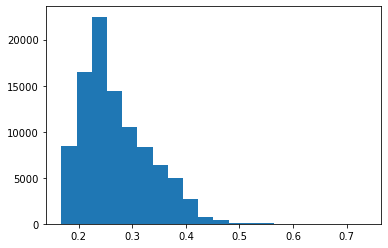

In [44]:
plt.hist(s_preds[s_preds<1.0],bins=20)